In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import os
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from regions import CircleSkyRegion
from gammapy.spectrum import (
    SpectrumDatasetOnOff,
    SpectrumDataset,
    SpectrumDatasetMaker,
)
from gammapy.modeling import Fit, Parameter
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SpectralModel,
    SkyModel,
    ExpCutoffPowerLawSpectralModel,
)
from gammapy.irf import load_cta_irfs
from gammapy.data import Observation
from gammapy.maps import MapAxis

In [3]:
livetime = 48 * u.h
pointing = SkyCoord(0, 0, unit="deg", frame="galactic")
offset = 0.5 * u.deg
# Reconstructed and true energy axis
energy_axis = MapAxis.from_edges(
    np.logspace(-1.5, 2.0, 10), unit="TeV", name="energy", interp="log"
)
energy_axis_true = MapAxis.from_edges(
    np.logspace(-1.5, 2.0, 31), unit="TeV", name="energy", interp="log"
)

on_region_radius = Angle("0.11 deg")
on_region = CircleSkyRegion(center=pointing, radius=on_region_radius)

In [4]:
# Define spectral model - a simple Power Law in this case
model_simu = ExpCutoffPowerLawSpectralModel(
    index=2.22,
    amplitude=1.289e-12 * u.Unit("cm-2 s-1 TeV-1"),
    reference=1 * u.TeV,
    lambda_=5 * u.Unit("TeV-1"),
    alpha = 1,
)
print(model_simu)
# we set the sky model used in the dataset
model = SkyModel(spectral_model=model_simu)

ExpCutoffPowerLawSpectralModel

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.289e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.000e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True


In [5]:
os.environ['CALDB'] = '/home/rishank/anaconda2/envs/cta/share/caldb/'
!echo $CALDB
!ls $CALDB

/home/rishank/anaconda2/envs/cta/share/caldb/
data


In [6]:
# Load the IRFs
# In this simulation, we use the CTA-1DC irfs shipped with gammapy.
irfs = load_cta_irfs(
    "$CALDB/data/cta/prod3b-v2/bcf/South_z20_50h/irf_file.fits"
)

In [7]:
obs = Observation.create(pointing=pointing, livetime=livetime, irfs=irfs)
print(obs)

Info for OBS_ID = 1
- Pointing pos: RA 266.40 deg / Dec -28.94 deg
- Livetime duration: 172800.0 s



In [8]:
# Make the SpectrumDataset
dataset_empty = SpectrumDataset.create(
    e_reco=energy_axis.edges, e_true=energy_axis_true.edges, region=on_region
)
maker = SpectrumDatasetMaker(selection=["aeff", "edisp", "background"])
dataset = maker.run(dataset_empty, obs)

In [9]:
# Set the model on the dataset, and fake
dataset.model = model
dataset.fake(random_state=42)
print(dataset)

SpectrumDataset

    Name                            : 1 

    Total counts                    : 20280 
    Total predicted counts          : nan
    Total background counts         : 20309.41

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 1.73e+05 s

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : cash
    Fit statistic value (-2 log(L)) : nan

    Number of parameters            : 0
    Number of free parameters       : 0




In [10]:
dataset_onoff = SpectrumDatasetOnOff(
    aeff=dataset.aeff,
    edisp=dataset.edisp,
    models=model,
    livetime=livetime,
    acceptance=1,
    acceptance_off=5,
)
dataset_onoff.fake(background_model=dataset.background)
print(dataset_onoff)

SpectrumDatasetOnOff

    Name                            :  

    Total counts                    : 26474 
    Total predicted counts          : 26372.93
    Total off counts                : 100948.00

    Total background counts         : 20189.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.95

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0



In [11]:

%%time

n_obs = 1000
datasets = []

for idx in range(n_obs):
    dataset_onoff.fake(random_state=idx, background_model=dataset.background)
    dataset_onoff.name = f"obs_{idx}"
    datasets.append(dataset_onoff.copy())

CPU times: user 4.06 s, sys: 19.6 ms, total: 4.08 s
Wall time: 4.09 s


In [12]:
print(*datasets, sep = "\n") 

SpectrumDatasetOnOff

    Name                            : obs_0 

    Total counts                    : 26536 
    Total predicted counts          : 26596.33
    Total off counts                : 102065.00

    Total background counts         : 20413.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.09

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1 

    Total counts                    : 26375 
    Total predicted counts          : 26517.73
    Total off counts                : 101672.00

    Total background counts         : 20

SpectrumDatasetOnOff

    Name                            : obs_29 

    Total counts                    : 26537 
    Total predicted counts          : 26515.13
    Total off counts                : 101659.00

    Total background counts         : 20331.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.87

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_30 

    Total counts                    : 26384 
    Total predicted counts          : 26514.13
    Total off counts                : 101654.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_46 

    Total counts                    : 26471 
    Total predicted counts          : 26494.53
    Total off counts                : 101556.00

    Total background counts         : 20311.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.91

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_47 

    Total counts                    : 26608 
    Total predicted counts          : 26612.53
    Total off counts                : 102146.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_73 

    Total counts                    : 26461 
    Total predicted counts          : 26392.53
    Total off counts                : 101046.00

    Total background counts         : 20209.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.81

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_74 

    Total counts                    : 26485 
    Total predicted counts          : 26487.33
    Total off counts                : 101520.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_91 

    Total counts                    : 26235 
    Total predicted counts          : 26523.13
    Total off counts                : 101699.00

    Total background counts         : 20339.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.42

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_92 

    Total counts                    : 26753 
    Total predicted counts          : 26525.93
    Total off counts                : 101713.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_106 

    Total counts                    : 26615 
    Total predicted counts          : 26451.73
    Total off counts                : 101342.00

    Total background counts         : 20268.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.50

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_107 

    Total counts                    : 26327 
    Total predicted counts          : 26556.33
    Total off counts                : 101865.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_119 

    Total counts                    : 26434 
    Total predicted counts          : 26476.13
    Total off counts                : 101464.00

    Total background counts         : 20292.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.33

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_120 

    Total counts                    : 26627 
    Total predicted counts          : 26383.53
    Total off counts                : 101001.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_146 

    Total counts                    : 26590 
    Total predicted counts          : 26541.93
    Total off counts                : 101793.00

    Total background counts         : 20358.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.71

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_147 

    Total counts                    : 26419 
    Total predicted counts          : 26306.33
    Total off counts                : 100615.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_157 

    Total counts                    : 26195 
    Total predicted counts          : 26403.73
    Total off counts                : 101102.00

    Total background counts         : 20220.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.97

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_158 

    Total counts                    : 26512 
    Total predicted counts          : 26592.53
    Total off counts                : 102046.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_171 

    Total counts                    : 26348 
    Total predicted counts          : 26507.53
    Total off counts                : 101621.00

    Total background counts         : 20324.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.42

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_172 

    Total counts                    : 26446 
    Total predicted counts          : 26507.13
    Total off counts                : 101619.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_186 

    Total counts                    : 26586 
    Total predicted counts          : 26466.73
    Total off counts                : 101417.00

    Total background counts         : 20283.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.46

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_187 

    Total counts                    : 26272 
    Total predicted counts          : 26492.53
    Total off counts                : 101546.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_198 

    Total counts                    : 26289 
    Total predicted counts          : 26452.93
    Total off counts                : 101348.00

    Total background counts         : 20269.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.87

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_199 

    Total counts                    : 26533 
    Total predicted counts          : 26522.53
    Total off counts                : 101696.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_215 

    Total counts                    : 26396 
    Total predicted counts          : 26519.53
    Total off counts                : 101681.00

    Total background counts         : 20336.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.20

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_216 

    Total counts                    : 26509 
    Total predicted counts          : 26422.13
    Total off counts                : 101194.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_229 

    Total counts                    : 26576 
    Total predicted counts          : 26576.73
    Total off counts                : 101967.00

    Total background counts         : 20393.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.21

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_230 

    Total counts                    : 26572 
    Total predicted counts          : 26443.33
    Total off counts                : 101300.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_246 

    Total counts                    : 26698 
    Total predicted counts          : 26481.33
    Total off counts                : 101490.00

    Total background counts         : 20298.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.55

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_247 

    Total counts                    : 26507 
    Total predicted counts          : 26493.33
    Total off counts                : 101550.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_257 

    Total counts                    : 26885 
    Total predicted counts          : 26426.73
    Total off counts                : 101217.00

    Total background counts         : 20243.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.80

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_258 

    Total counts                    : 26312 
    Total predicted counts          : 26473.53
    Total off counts                : 101451.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_274 

    Total counts                    : 26222 
    Total predicted counts          : 26473.13
    Total off counts                : 101449.00

    Total background counts         : 20289.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.05

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_275 

    Total counts                    : 26393 
    Total predicted counts          : 26537.73
    Total off counts                : 101772.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_285 

    Total counts                    : 26439 
    Total predicted counts          : 26555.33
    Total off counts                : 101860.00

    Total background counts         : 20372.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.09

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_286 

    Total counts                    : 26433 
    Total predicted counts          : 26439.13
    Total off counts                : 101279.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_306 

    Total counts                    : 26275 
    Total predicted counts          : 26441.73
    Total off counts                : 101292.00

    Total background counts         : 20258.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.50

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_307 

    Total counts                    : 26474 
    Total predicted counts          : 26594.73
    Total off counts                : 102057.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_317 

    Total counts                    : 26490 
    Total predicted counts          : 26440.13
    Total off counts                : 101284.00

    Total background counts         : 20256.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.59

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_318 

    Total counts                    : 26627 
    Total predicted counts          : 26474.73
    Total off counts                : 101457.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_335 

    Total counts                    : 26509 
    Total predicted counts          : 26413.33
    Total off counts                : 101150.00

    Total background counts         : 20230.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.03

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_336 

    Total counts                    : 26707 
    Total predicted counts          : 26430.13
    Total off counts                : 101234.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_347 

    Total counts                    : 26348 
    Total predicted counts          : 26418.13
    Total off counts                : 101174.00

    Total background counts         : 20234.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.51

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_348 

    Total counts                    : 26529 
    Total predicted counts          : 26606.33
    Total off counts                : 102115.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_367 

    Total counts                    : 26057 
    Total predicted counts          : 26462.73
    Total off counts                : 101397.00

    Total background counts         : 20279.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.62

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_368 

    Total counts                    : 26606 
    Total predicted counts          : 26502.93
    Total off counts                : 101598.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_380 

    Total counts                    : 26562 
    Total predicted counts          : 26601.93
    Total off counts                : 102093.00

    Total background counts         : 20418.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 14.78

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_381 

    Total counts                    : 26565 
    Total predicted counts          : 26601.33
    Total off counts                : 102090.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_398 

    Total counts                    : 26298 
    Total predicted counts          : 26407.93
    Total off counts                : 101123.00

    Total background counts         : 20224.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.04

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_399 

    Total counts                    : 26299 
    Total predicted counts          : 26541.53
    Total off counts                : 101791.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_410 

    Total counts                    : 26502 
    Total predicted counts          : 26387.53
    Total off counts                : 101021.00

    Total background counts         : 20204.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.45

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_411 

    Total counts                    : 26519 
    Total predicted counts          : 26497.93
    Total off counts                : 101573.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_427 

    Total counts                    : 26608 
    Total predicted counts          : 26436.93
    Total off counts                : 101268.00

    Total background counts         : 20253.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.22

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_428 

    Total counts                    : 26266 
    Total predicted counts          : 26508.93
    Total off counts                : 101628.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_440 

    Total counts                    : 26759 
    Total predicted counts          : 26414.93
    Total off counts                : 101158.00

    Total background counts         : 20231.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.96

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_441 

    Total counts                    : 26596 
    Total predicted counts          : 26548.53
    Total off counts                : 101826.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_459 

    Total counts                    : 26403 
    Total predicted counts          : 26490.53
    Total off counts                : 101536.00

    Total background counts         : 20307.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.50

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_460 

    Total counts                    : 26442 
    Total predicted counts          : 26559.13
    Total off counts                : 101879.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_471 

    Total counts                    : 26518 
    Total predicted counts          : 26521.53
    Total off counts                : 101691.00

    Total background counts         : 20338.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.82

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_472 

    Total counts                    : 26519 
    Total predicted counts          : 26432.53
    Total off counts                : 101246.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_491 

    Total counts                    : 26198 
    Total predicted counts          : 26529.33
    Total off counts                : 101730.00

    Total background counts         : 20346.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 15.81

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_492 

    Total counts                    : 26360 
    Total predicted counts          : 26519.13
    Total off counts                : 101679.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_503 

    Total counts                    : 26640 
    Total predicted counts          : 26495.93
    Total off counts                : 101563.00

    Total background counts         : 20312.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.88

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_504 

    Total counts                    : 26554 
    Total predicted counts          : 26559.73
    Total off counts                : 101882.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_523 

    Total counts                    : 26107 
    Total predicted counts          : 26592.33
    Total off counts                : 102045.00

    Total background counts         : 20409.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 19.59

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_524 

    Total counts                    : 26563 
    Total predicted counts          : 26605.53
    Total off counts                : 102111.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_535 

    Total counts                    : 26517 
    Total predicted counts          : 26459.33
    Total off counts                : 101380.00

    Total background counts         : 20276.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.25

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_536 

    Total counts                    : 26465 
    Total predicted counts          : 26566.73
    Total off counts                : 101917.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_555 

    Total counts                    : 26672 
    Total predicted counts          : 26462.53
    Total off counts                : 101396.00

    Total background counts         : 20279.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.24

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_556 

    Total counts                    : 26553 
    Total predicted counts          : 26448.73
    Total off counts                : 101327.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_568 

    Total counts                    : 26298 
    Total predicted counts          : 26445.13
    Total off counts                : 101309.00

    Total background counts         : 20261.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.82

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_569 

    Total counts                    : 26592 
    Total predicted counts          : 26508.73
    Total off counts                : 101627.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_582 

    Total counts                    : 26681 
    Total predicted counts          : 26445.13
    Total off counts                : 101309.00

    Total background counts         : 20261.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.27

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_583 

    Total counts                    : 26392 
    Total predicted counts          : 26520.93
    Total off counts                : 101688.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_605 

    Total counts                    : 26583 
    Total predicted counts          : 26529.73
    Total off counts                : 101732.00

    Total background counts         : 20346.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.59

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_606 

    Total counts                    : 26375 
    Total predicted counts          : 26490.53
    Total off counts                : 101536.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_616 

    Total counts                    : 26591 
    Total predicted counts          : 26333.73
    Total off counts                : 100752.00

    Total background counts         : 20150.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.31

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_617 

    Total counts                    : 26558 
    Total predicted counts          : 26465.93
    Total off counts                : 101413.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_633 

    Total counts                    : 26489 
    Total predicted counts          : 26498.33
    Total off counts                : 101575.00

    Total background counts         : 20315.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.62

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_634 

    Total counts                    : 26865 
    Total predicted counts          : 26564.93
    Total off counts                : 101908.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_644 

    Total counts                    : 26270 
    Total predicted counts          : 26471.33
    Total off counts                : 101440.00

    Total background counts         : 20288.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.19

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_645 

    Total counts                    : 26655 
    Total predicted counts          : 26523.13
    Total off counts                : 101699.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_661 

    Total counts                    : 26582 
    Total predicted counts          : 26503.13
    Total off counts                : 101599.00

    Total background counts         : 20319.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 1.84

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_662 

    Total counts                    : 26220 
    Total predicted counts          : 26572.13
    Total off counts                : 101944.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_673 

    Total counts                    : 26462 
    Total predicted counts          : 26532.73
    Total off counts                : 101747.00

    Total background counts         : 20349.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.28

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_674 

    Total counts                    : 26245 
    Total predicted counts          : 26521.53
    Total off counts                : 101691.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_690 

    Total counts                    : 26462 
    Total predicted counts          : 26559.73
    Total off counts                : 101882.00

    Total background counts         : 20376.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.16

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_691 

    Total counts                    : 26550 
    Total predicted counts          : 26511.33
    Total off counts                : 101640.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_714 

    Total counts                    : 26217 
    Total predicted counts          : 26476.33
    Total off counts                : 101465.00

    Total background counts         : 20293.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.60

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_715 

    Total counts                    : 26414 
    Total predicted counts          : 26632.33
    Total off counts                : 102245.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_733 

    Total counts                    : 26480 
    Total predicted counts          : 26371.13
    Total off counts                : 100939.00

    Total background counts         : 20187.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.25

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_734 

    Total counts                    : 26706 
    Total predicted counts          : 26507.53
    Total off counts                : 101621.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_759 

    Total counts                    : 26618 
    Total predicted counts          : 26368.13
    Total off counts                : 100924.00

    Total background counts         : 20184.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.17

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_760 

    Total counts                    : 26263 
    Total predicted counts          : 26507.73
    Total off counts                : 101622.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_784 

    Total counts                    : 26365 
    Total predicted counts          : 26490.93
    Total off counts                : 101538.00

    Total background counts         : 20307.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.87

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_785 

    Total counts                    : 26194 
    Total predicted counts          : 26409.13
    Total off counts                : 101129.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_812 

    Total counts                    : 26575 
    Total predicted counts          : 26538.33
    Total off counts                : 101775.00

    Total background counts         : 20355.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.83

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_813 

    Total counts                    : 26093 
    Total predicted counts          : 26449.33
    Total off counts                : 101330.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_838 

    Total counts                    : 26412 
    Total predicted counts          : 26532.33
    Total off counts                : 101745.00

    Total background counts         : 20349.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.47

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_839 

    Total counts                    : 26308 
    Total predicted counts          : 26475.13
    Total off counts                : 101459.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_851 

    Total counts                    : 26320 
    Total predicted counts          : 26454.73
    Total off counts                : 101357.00

    Total background counts         : 20271.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.91

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_852 

    Total counts                    : 26289 
    Total predicted counts          : 26453.33
    Total off counts                : 101350.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_869 

    Total counts                    : 26369 
    Total predicted counts          : 26386.33
    Total off counts                : 101015.00

    Total background counts         : 20203.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.90

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_870 

    Total counts                    : 26274 
    Total predicted counts          : 26571.13
    Total off counts                : 101939.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_896 

    Total counts                    : 26662 
    Total predicted counts          : 26541.93
    Total off counts                : 101793.00

    Total background counts         : 20358.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.43

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_897 

    Total counts                    : 26438 
    Total predicted counts          : 26555.53
    Total off counts                : 101861.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_908 

    Total counts                    : 26424 
    Total predicted counts          : 26516.73
    Total off counts                : 101667.00

    Total background counts         : 20333.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.94

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_909 

    Total counts                    : 26369 
    Total predicted counts          : 26438.13
    Total off counts                : 101274.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_927 

    Total counts                    : 26387 
    Total predicted counts          : 26569.53
    Total off counts                : 101931.00

    Total background counts         : 20386.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.63

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_928 

    Total counts                    : 26512 
    Total predicted counts          : 26467.93
    Total off counts                : 101423.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_940 

    Total counts                    : 26290 
    Total predicted counts          : 26563.73
    Total off counts                : 101902.00

    Total background counts         : 20380.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.09

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_941 

    Total counts                    : 26570 
    Total predicted counts          : 26435.13
    Total off counts                : 101259.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_959 

    Total counts                    : 26449 
    Total predicted counts          : 26456.73
    Total off counts                : 101367.00

    Total background counts         : 20273.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.02

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_960 

    Total counts                    : 26656 
    Total predicted counts          : 26499.53
    Total off counts                : 101581.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_982 

    Total counts                    : 26218 
    Total predicted counts          : 26450.53
    Total off counts                : 101336.00

    Total background counts         : 20267.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.41

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_983 

    Total counts                    : 26451 
    Total predicted counts          : 26518.33
    Total off counts                : 101675.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_996 

    Total counts                    : 26670 
    Total predicted counts          : 26542.33
    Total off counts                : 101795.00

    Total background counts         : 20359.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.65

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_997 

    Total counts                    : 26310 
    Total predicted counts          : 26444.33
    Total off counts                : 101305.00

    Total background counts         

Text(0, 0.5, 'No. of observations')

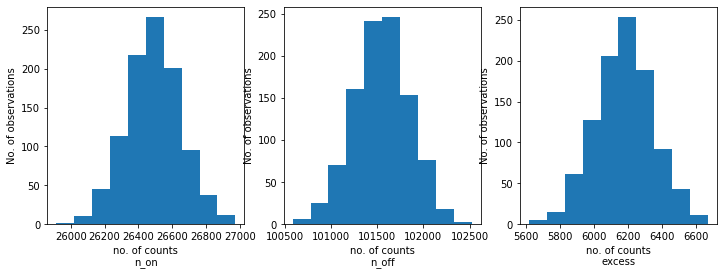

In [13]:

n_on = [dataset.counts.data.sum() for dataset in datasets]
n_off = [dataset.counts_off.data.sum() for dataset in datasets]
excess = [dataset.excess.data.sum() for dataset in datasets]

fix, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].hist(n_on)
axes[0].set_xlabel("no. of counts\nn_on")
axes[0].set_ylabel("No. of observations")
axes[1].hist(n_off)
axes[1].set_xlabel("no. of counts\nn_off")
axes[1].set_ylabel("No. of observations")
axes[2].hist(excess)
axes[2].set_xlabel("no. of counts\nexcess");
axes[2].set_ylabel("No. of observations")

In [14]:

%%time
results = []
for dataset in datasets:
    dataset.models = model.copy()
    fit = Fit([dataset])
    result = fit.optimize()
    results.append(
        {
            "index": result.parameters["index"].value,
            "amplitude": result.parameters["amplitude"].value,
            "lambda_": result.parameters["lambda_"].value,
        }
    )

CPU times: user 8min 18s, sys: 2.58 s, total: 8min 21s
Wall time: 11min 56s


In [15]:
results

[{'index': 2.169752569491976,
  'amplitude': 1.5653134721691003e-12,
  'lambda_': 5.7304570878812315},
 {'index': 2.393488523746745,
  'amplitude': 7.286175300846211e-13,
  'lambda_': 3.905504304079907},
 {'index': 2.05674633444537,
  'amplitude': 2.13609661023113e-12,
  'lambda_': 5.906316554578479},
 {'index': 2.2198891624283323,
  'amplitude': 1.2639851286831836e-12,
  'lambda_': 4.8690788872207404},
 {'index': 2.0251566902172473,
  'amplitude': 2.9214173989377874e-12,
  'lambda_': 7.501668200451735},
 {'index': 2.1591183874381765,
  'amplitude': 1.5123358711152705e-12,
  'lambda_': 5.317593059653128},
 {'index': 2.27786551050091,
  'amplitude': 1.18748129290514e-12,
  'lambda_': 5.30901410394558},
 {'index': 1.957657038806865,
  'amplitude': 2.9654928839917636e-12,
  'lambda_': 6.744542519944392},
 {'index': 2.367028293033707,
  'amplitude': 7.803183909775817e-13,
  'lambda_': 3.9453878125603405},
 {'index': 2.3072870942101904,
  'amplitude': 9.87768208600471e-13,
  'lambda_': 4.52

index: 2.2060606597480463 += 0.137096909695096


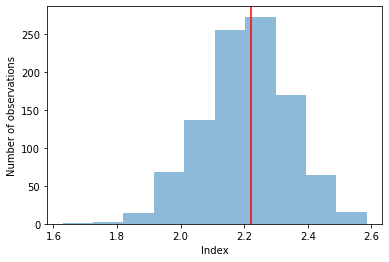

In [16]:
index = np.array([_["index"] for _ in results])
plt.hist(index, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["index"].value, color="red")
plt.xlabel("Index")
plt.ylabel("Number of observations")
print(f"index: {index.mean()} += {index.std()}")

amplitude: 1.4841968226111473e-12 += 7.09176445369075e-13


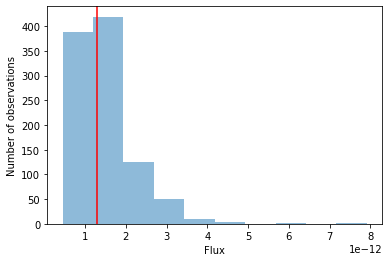

In [17]:
amplitude = np.array([_["amplitude"] for _ in results])
plt.hist(amplitude, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["amplitude"].value, color="red")
plt.xlabel("Flux")
plt.ylabel("Number of observations")
print(f"amplitude: {amplitude.mean()} += {amplitude.std()}")

lambda_: 5.116847908726059 += 0.9653616264515855


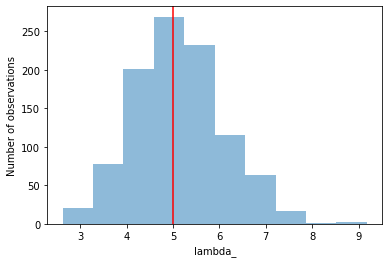

In [18]:
lambda_ = np.array([_["lambda_"] for _ in results])
plt.hist(lambda_, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["lambda_"].value, color="red")
plt.xlabel("lambda_")
plt.ylabel("Number of observations")
print(f"lambda_: {lambda_.mean()} += {lambda_.std()}")